<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Sigmoid%20Neuron/Liver%20Patient%20Diagnosis/LiverPatientDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/Udacity/Dataset/")
!ls

adc.json  drive  sample_data
E: Package 'python-software-properties' has no installation candidate
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
indian_liver_patient.csv  mobile.csv  perceptron.csv  student_data.csv


## Load the Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook

In [3]:
patient = pd.read_csv('indian_liver_patient.csv')
print(type(patient))
print(patient.shape)

<class 'pandas.core.frame.DataFrame'>
(583, 11)


In [4]:
gender = pd.get_dummies(patient['Gender'])
patient = pd.concat([patient,gender], axis=1)

In [5]:
patient['class'] = (patient["Dataset"]==1) * 1
patient = patient.drop(['Dataset'],axis=1)
patient = patient.drop(['Gender'],axis=1)
print("Class is 1 if patient needs liver diagnosis and 0 i don't")

Class is 1 if patient needs liver diagnosis and 0 i don't


In [6]:
print(patient['class'].value_counts())
print(patient['class'].value_counts(normalize=True))

1    416
0    167
Name: class, dtype: int64
1    0.713551
0    0.286449
Name: class, dtype: float64


In [7]:
patient.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Female,Male,class
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1,0,1
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,0,1,1
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,0,1,1
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,0,1,1
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,0,1,1


In [8]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Total_Bilirubin             583 non-null    float64
 2   Direct_Bilirubin            583 non-null    float64
 3   Alkaline_Phosphotase        583 non-null    int64  
 4   Alamine_Aminotransferase    583 non-null    int64  
 5   Aspartate_Aminotransferase  583 non-null    int64  
 6   Total_Protiens              583 non-null    float64
 7   Albumin                     583 non-null    float64
 8   Albumin_and_Globulin_Ratio  579 non-null    float64
 9   Female                      583 non-null    uint8  
 10  Male                        583 non-null    uint8  
 11  class                       583 non-null    int64  
dtypes: float64(5), int64(5), uint8(2)
memory usage: 46.8 KB


In [9]:
patient.dropna(subset = ["Albumin_and_Globulin_Ratio"], inplace=True)
patient.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 582
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         579 non-null    int64  
 1   Total_Bilirubin             579 non-null    float64
 2   Direct_Bilirubin            579 non-null    float64
 3   Alkaline_Phosphotase        579 non-null    int64  
 4   Alamine_Aminotransferase    579 non-null    int64  
 5   Aspartate_Aminotransferase  579 non-null    int64  
 6   Total_Protiens              579 non-null    float64
 7   Albumin                     579 non-null    float64
 8   Albumin_and_Globulin_Ratio  579 non-null    float64
 9   Female                      579 non-null    uint8  
 10  Male                        579 non-null    uint8  
 11  class                       579 non-null    int64  
dtypes: float64(5), int64(5), uint8(2)
memory usage: 50.9 KB


In [10]:
X = patient[patient.columns.difference(['class'])]
Y = patient['class']

##Train Test Split

In [11]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1,stratify=Y,random_state=1)
print(X.shape,X_train.shape,X_test.shape)
print(Y.shape,Y_train.shape,Y_test.shape)

(579, 11) (521, 11) (58, 11)
(579,) (521,) (58,)


## Standardisation

In [12]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)


## Model

In [13]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        dw += self.grad_w(x, y)
        db += self.grad_b(x, y)       
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        loss[i] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      plt.plot(list(loss.values()))
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


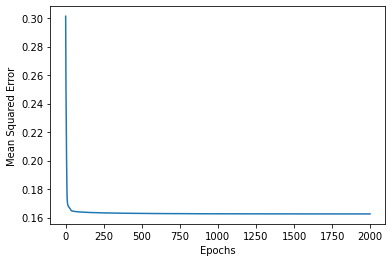

In [14]:
sn = SigmoidNeuron()
sn.fit(X_scaled_train, Y_train, epochs=2000, learning_rate=0.015, display_loss=True)

In [15]:
Y_pred_train = sn.predict(X_scaled_train)
Y_pred_test = sn.predict(X_scaled_test)

## Standardisation of Predictions

In [16]:
Y_pred_std_train = ((Y_pred_train) > (1-Y_pred_train))*1 
Y_pred_std_test = ((Y_pred_test) > (1-Y_pred_test))*1 

## Accuracy check

In [17]:
accuracy_train = accuracy_score(Y_pred_std_train, Y_train)
accuracy_test  = accuracy_score(Y_pred_std_test, Y_test)
print(accuracy_train, accuracy_test)

0.7332053742802304 0.6206896551724138
